In [2]:
seed = 0

import os
import sys

os.chdir('..')
utils_path = os.path.abspath("./utilities/")
sys.path.append(utils_path)

from load_data import load_fullECAI
from evaluation import *
from evaluation import _my_scorer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, Normalizer
from sklearn.metrics import euclidean_distances
import joblib
from joblib import Parallel, delayed
import shap

from igraph import Graph
import igraph as ig

/home/azaelcarrillo/miniconda3/envs/XAI_credit/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import powerlaw

In [283]:
def mean_degree(g):
    degree = g.degree_distribution()
    
    return degree.mean

def mean_dist_node_pairs(g):
    return


def exp_power_law_degrees(g):
    degrees = g.degree(g.vs)
    fitted = ig.statistics.power_law_fit(degrees)
    
    return fitted.alpha, fitted.xmin, fitted.p

def exp_power_law_alternative(g):
    degrees = g.degree(g.vs)
    results = powerlaw.Fit(data)
    
    return results.power_law.alpha, results.power_law.xmin

def exp_power_law_strengths(g):
    """
    H0: data was drawn from the fitted distribution

    """
    strengths = g.strength(g.vs, weights=1/(1+np.array(g.es['weight'])))
    fitted = ig.statistics.power_law_fit(strengths)
    
    return fitted.alpha, fitted.xmin, fitted.p


def cluster_coeff(g):
    return g.transitivity_undirected()


def random_cluster_coeff(g):
    n = g.vcount()
    degrees = g.degree(g.vs, loops=False)
    unique_degrees, degree_freqs = np.unique(degrees, return_counts=True)
    prop_degrees = degree_freqs/n
    moment_1 = np.dot(unique_degrees, prop_degrees)
    moment_2 = np.dot(unique_degrees**2, prop_degrees)
    
    return (1/n) * ((moment_2 - moment_1)**2) / (moment_1**3)


def assortativity_degree(g):
    assortativity = g.assortativity_degree(directed=False)
    return assortativity


def modularity(g, cats):
    # Checar si este es con distancias o fuerzas
    mod = g.modularity(cats.tolist(), weights=1/(1+np.array(g.es['weight'])))
    return mod

def summary(result, results_model, model_name):
    if result[1] == -1:
        # No calcular si la matriz no tiene conexiones
        return
    
    y_pred = results_model['y_pred']
    
    summary_stats = {}
    summary_stats['modelo'] = model_name
    summary_stats['corte'] = result[0]
    summary_stats['global_efficiency'] = result[1]
    summary_stats['aristas'] = result[2]
    summary_stats['mean_degree'] = mean_degree(result[3])
    
    # alpha, xmin, p = exp_power_law_degrees(result[3])
    # summary_stats['pow_degree_alpha'] = alpha
    # summary_stats['pow_degree_xmin'] = xmin
    # summary_stats['pow_degree_p'] = p
    
    # alpha, xmin, p = exp_power_law_strengths(result[3])
    # summary_stats['pow_str_alpha'] = alpha
    # summary_stats['pow_str_xmin'] = xmin
    # summary_stats['pow_str_p'] = p
    
    summary_stats['cluster_coeff'] = cluster_coeff(result[3])
    summary_stats['modularity'] = modularity(result[3], y_pred)
    summary_stats['Assort. degree'] = assortativity_degree(result[3])
    
    return summary_stats

def summary_handler(reduced_graphs_path, rgraph_pkl, model_name):
    """
    Parameters
    ----------
    path: str
        Path of pkl file of a sinlgle reduced graph result object
    """
    path = reduced_graphs_path + '/' + rgraph_pkl
    results_graph = joblib.load(path)
    summary_stats = summary(results_graph, results_model, model_name)
    if summary_stats:
        summary_stats['NAME'] = rgraph_pkl
    return summary_stats

def main_summary(identifier, n_jobs=6):
    """
    Parameters
    ----------
    identifier: str
        Name of folder containing reduced graphs
        
    n_jobs: int
        Number of parallel threads
    Example
    ----------
    > df = main_summary('reduced_graphs')
    """
    datas = []
    for model in models_paths:
        model_folder = '/'.join(model.split('/')[:-1])
        model_name = model.split('/')[-1].split('.')[0]

        reduced_graphs_path = '{}/{}/{}'.format(model_folder, identifier, model_name)
        reduced_graphs_pkl = os.listdir(reduced_graphs_path)
        if '.ipynb_checkpoints' in reduced_graphs_pkl:
            reduced_graphs_pkl.remove('.ipynb_checkpoints')
        results_model = joblib.load(model)

        data = Parallel(n_jobs=n_jobs)(delayed(summary_handler)(reduced_graphs_path, rgraph_pkl, model_name) for rgraph_pkl in reduced_graphs_pkl)
        data = list(filter(None, data)) # Some graphs are non-conected so summary returns None instead of a dict
        datas = datas + data

    stats_df = pd.DataFrame(datas)

    stats_df = (
        stats_df
        .set_index(['modelo', 'corte'])
        .sort_values(['modelo', 'corte'])
    )

    stats_df['per_max_eff'] = stats_df.global_efficiency / stats_df.groupby('modelo').global_efficiency.transform(np.max)
    
    stats_df.rename({'LinearDiscriminantAnalysis': 'LDA', 
                     'LogisticRegression':'LR', 
                     'RandomForestClassifier':'RF', 
                     'best_xgb':'XGBB'}, 
                    inplace=True)
    
    stats_df.drop_duplicates(inplace=True)
    
    # Optimal graphs
    stats_df['OPTIMAL'] = False
    idx = stats_df[stats_df['per_max_eff'] > .80].groupby('modelo').head(1).index
    stats_df.loc[idx, 'OPTIMAL'] = True

    return stats_df

In [5]:
dataset = load_fullECAI()
# Prep data
X = dataset.drop('status', axis=1)
y = dataset.loc[:, 'status']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=seed, stratify=y)

In [6]:
models_paths = ['./results/XGBoost/GridSearchCV_22-03-22_03-27-03/models/best/best_xgb.pkl', 
                './results/Basic1/models/RandomForestClassifier.pkl',
                './results/Basic1/models/LogisticRegression.pkl',
                './results/Basic1/models/LinearDiscriminantAnalysis.pkl'
               ]

## Main summary table

In [215]:
stats_df = main_summary('reduced_graphs_even_spaces')

In [165]:
np.unique(stats_df.index.get_level_values(0))

array(['LDA', 'LR', 'RF', 'XGBB'], dtype=object)

In [211]:
stats_df.loc['LDA']
# De .005 en .005

,global_efficiency,aristas,mean_degree,cluster_coeff,modularity,Assort. degree,NAME,per_max_eff
corte,,,,,,,,
0.0014,145.295298,199802,132.802925,0.826892,0.000000,0.676027,reduced_140.pkl,0.661560
0.0016,156.203666,244501,162.513127,0.829074,0.000000,0.675829,reduced_160.pkl,0.711228
0.0018,165.569648,291602,193.819874,0.826865,0.000014,0.657758,reduced_180.pkl,0.753873
0.0020,172.297718,343202,228.116982,0.825626,0.000035,0.638030,reduced_200.pkl,0.784508
0.0022,176.546775,396959,263.847790,0.823312,0.000040,0.618550,reduced_220.pkl,0.803855
0.0024,181.321264,453815,301.638418,0.822096,0.000053,0.600831,reduced_239.pkl,0.825594
0.0026,186.900700,512092,340.373546,0.822066,0.000066,0.581851,reduced_260.pkl,0.850998
0.0028,190.972904,574820,382.067132,0.824106,0.000066,0.567136,reduced_280.pkl,0.869540
0.0030,194.817493,638574,424.442672,0.828208,0.000088,0.562200,reduced_300.pkl,0.887045


## Codos

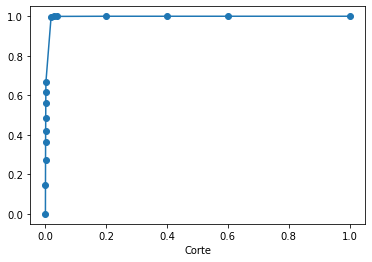

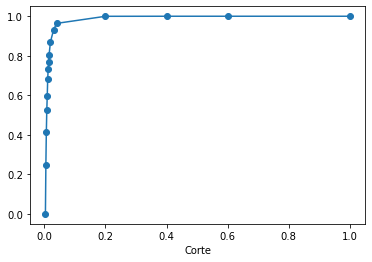

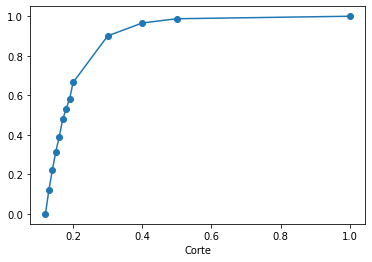

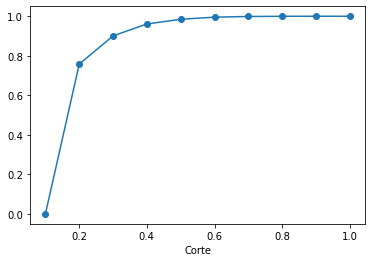

In [216]:
modelos = np.unique(stats_df.index.get_level_values('modelo'))
for modelo in modelos:
    eff = stats_df.loc[modelo].global_efficiency
    eff = (eff - np.min(eff))/(np.max(eff) - np.min(eff))
    co = stats_df.loc[modelo].index.to_numpy()
    plt.plot(co, eff)
    plt.scatter(co, eff)
    #plt.xscale('log')
    plt.xticks()
    #plt.xlim(0, 0.1)
    plt.xlabel('Corte')
    plt.savefig('results/figures/graphs/codos/{}_codo_log.png'.format(modelo), bbox_inches='tight', dpi=300, transparent=True)
    plt.show()

## Optimal graphs

In [198]:
def arg_find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

stats_df.groupby('modelo').apply(lambda x: x.reset_index().iloc[arg_find_nearest(x.per_max_eff, .8)])

,modelo,corte,global_efficiency,aristas,mean_degree,cluster_coeff,modularity,Assort. degree,NAME,per_max_eff
modelo,,,,,,,,,,
LDA,LDA,0.00225,177.753728,411085,273.236956,0.822598,4.862086e-05,0.614158,reduced_224.pkl,0.809350
LR,LR,0.00900,26.776187,250866,166.743769,0.831408,-1.264536e-10,0.707343,reduced_899.pkl,0.790499
RF,RF,0.15000,3.376934,623882,414.677301,0.693328,3.566893e-04,0.443948,reduced_15000.pkl,0.788646
XGBB,XGBB,0.20000,2.373301,349511,232.310402,0.611964,1.741794e-03,0.455577,reduced_20000.pkl,0.818252


## Power Law

In [ ]:
stats_total = []
for model in models_paths:
    stats_tmp = stats_by_model(model)
    stats_total = stats_total + stats_tmp
stats_df = pd.DataFrame(stats_total)
stats_df['per_max_eff'] = stats_df.global_efficiency / stats_df.groupby('modelo').global_efficiency.transform(np.max)

stats_df.loc[stats_df.pow_degree_p > .1, 'degree_sig'] = ''
stats_df.loc[stats_df.pow_degree_p < .1, 'degree_sig'] = '*'
stats_df.loc[stats_df.pow_degree_p < .05, 'degree_sig'] = '**'
stats_df.loc[stats_df.pow_degree_p < .01, 'degree_sig'] = '***'

stats_df.loc[stats_df.pow_str_p > .1, 'str_sig'] = ''
stats_df.loc[stats_df.pow_str_p < .1, 'str_sig'] = '*'
stats_df.loc[stats_df.pow_str_p < .05, 'str_sig'] = '**'
stats_df.loc[stats_df.pow_str_p < .01, 'str_sig'] = '***'

In [244]:
stats_df

global_efficiency  aristas  mean_degree  cluster_coeff  \
modelo corte                                                            
LDA    0.0014         145.295298   199802   132.802925       0.826892   
       0.0016         156.203666   244501   162.513127       0.829074   
       0.0018         165.569648   291602   193.819874       0.826865   
       0.0020         172.297718   343202   228.116982       0.825626   
       0.0022         176.546775   396959   263.847790       0.823312   
       0.0024         181.321264   453815   301.638418       0.822096   
       0.0026         186.900700   512092   340.373546       0.822066   
       0.0028         190.972904   574820   382.067132       0.824106   
       0.0030         194.817493   638574   424.442672       0.828208   
       0.0200         219.381728  3949070  2624.838817       0.980232   
       0.0300         219.545838  4293971  2854.085078       0.992954   
       0.0400         219.571159  4409428  2930.826188       0.997650   
       0.2000         219.624575  4517246  3002.489864       0.999875   
       0.4000         219.624585  4522528  3006.000665       1.000000   
       0.6000         219.624585  4522528  3006.000665       1.000000   
       1.0000         219.625253  4525536  3008.000000       1.000000   
LR     0.0035          17.042573    53965    35.869059       0.772812   
       0.0050          21.248108   100145    66.563642       0.790127   
       0.0065          23.997180   153426   101.978066       0.810021   
       0.0080          25.872088   211990   140.903955       0.824907   
       0.0095          27.098084   270363   179.702891       0.833336   
       0.0110          28.536342   330945   219.970090       0.837425   
       0.0125          29.372763   393489   261.541376       0.843828   
       0.0140          29.990683   457099   303.821203       0.852239   
       0.0155          30.598023   516924   343.585244       0.855775   
       0.0200          31.685008   707170   470.036557       0.864088   
       0.0300          32.698262  1099129   730.560984       0.883976   
       0.0400          33.264000  1440871   957.707544       0.898041   
       0.2000          33.868036  3810814  2532.943835       0.978407   
       0.4000          33.872328  4333581  2880.412762       0.991987   
       0.6000          33.872506  4502552  2992.723164       0.998569   
       1.0000          33.872513  4525536  3008.000000       1.000000   
RF     0.1200           2.962477   316503   210.370887       0.628647   
       0.1300           3.121904   410892   273.108674       0.651045   
       0.1400           3.256410   514004   341.644400       0.672964   
       0.1500           3.376934   623882   414.677301       0.693328   
       0.1600           3.478893   740737   492.347624       0.711214   
       0.1700           3.593217   862068   572.993021       0.727550   
       0.1800           3.665586   988067   656.741110       0.742321   
       0.1900           3.731329  1116427   742.058491       0.756553   
       0.2000           3.839723  1245807   828.053838       0.769968   
       0.3000           4.150744  2506029  1665.688933       0.857385   
       0.4000           4.236932  3505568  2330.055168       0.934897   
       0.5000           4.265319  4031236  2679.452310       0.973845   
       1.0000           4.281938  4525536  3008.000000       1.000000   
XGBB   0.1000           0.723244    18493    12.291791       0.596248   
       0.2000           2.373301   349511   232.310402       0.611964   
       0.3000           2.683886  1237054   822.235959       0.714438   
       0.4000           2.815292  2280376  1515.703556       0.825892   
       0.5000           2.867092  3182820  2115.533400       0.856067   
       0.6000           2.890231  3970840  2639.308740       0.927808   
       0.7000           2.897710  4329198  2877.499501       0.970466   
       0.8000           2.899895  4473377  2973.331339       0.990399   


In [282]:
# Optimal

stats_df.loc[stats_df.OPTIMAL==True]

,,global_efficiency,aristas,mean_degree,cluster_coeff,modularity,Assort. degree,NAME,per_max_eff,OPT,OPTIMAL
modelo,corte,,,,,,,,,,
LDA,0.0022,176.546775,396959,263.847790,0.823312,0.000040,0.618550,reduced_220.pkl,0.803855,False,True
LR,0.0095,27.098084,270363,179.702891,0.833336,0.000015,0.703064,reduced_950.pkl,0.800002,False,True
RF,0.1600,3.478893,740737,492.347624,0.711214,0.000378,0.434253,reduced_16000.pkl,0.812458,False,True
XGBB,0.2000,2.373301,349511,232.310402,0.611964,0.001742,0.455577,reduced_20000.pkl,0.818252,False,True


## Format table

In [340]:
'{{{a}}}'.format(a=2)

'{2}'

,,Eficiencia global,aristas,Grado medio,Coef. agrupamiento,modularity,Assort. degree,\% Max efi.,OPT,OPTIMAL
modelo,corte,,,,,,,,,
LDA,0.0022,\textbf{176.55},\textbf{396959},\textbf{263.85},\textbf{0.8233},\textbf{0.00004},\textbf{0.6186},\textbf{80.39\%},\textbf{False},\textbf{True}
LR,0.0095,\textbf{27.10},\textbf{270363},\textbf{179.70},\textbf{0.8333},\textbf{0.00001},\textbf{0.7031},\textbf{80.00\%},\textbf{False},\textbf{True}
RF,0.1600,\textbf{3.48},\textbf{740737},\textbf{492.35},\textbf{0.7112},\textbf{0.00038},\textbf{0.4343},\textbf{81.25\%},\textbf{False},\textbf{True}
XGBB,0.2000,\textbf{2.37},\textbf{349511},\textbf{232.31},\textbf{0.6120},\textbf{0.00174},\textbf{0.4556},\textbf{81.83\%},\textbf{False},\textbf{True}


In [344]:
# Tabla general
# Solo alrededor del corte optimo
# Modelo, submodelo por corte
main_table = stats_df.copy()
main_table.drop(labels=['NAME'], axis=1, inplace=True)
main_table.drop_duplicates(inplace=True)


main_table['per_max_eff'] = main_table['per_max_eff'].apply(lambda x: str('{:.2f}\%'.format(x*100)))
main_table['modularity'] = main_table['modularity'].apply(lambda x: str('{:.5f}'.format(x)) )
main_table['Assort. degree'] = main_table['Assort. degree'].apply(lambda x: str('{:.4f}'.format(x)) )
main_table['global_efficiency'] = main_table['global_efficiency'].apply(lambda x: str('{:.2f}'.format(x)) )
main_table['mean_degree'] = main_table['mean_degree'].apply(lambda x: str('{:.2f}'.format(x)) )
main_table['cluster_coeff'] = main_table['cluster_coeff'].apply(lambda x: str('{:.4f}'.format(x)) )

main_table.loc[main_table.OPTIMAL==True,:] = main_table.loc[main_table.OPTIMAL==True,:].applymap(lambda x: '\\textbf{{{A}}}'.format(A=str(x)))
main_table.drop(labels=['OPTIMAL'], axis=1, inplace=True)


styler = main_table.style
styler.format_index('{:.4f}', level=1)

main_table.rename({'global_efficiency':'Eficiencia global', 
                   'mean_degree':'Grado medio', 
                   'cluster_coeff':'Coef. agrupamiento', 
                   'per_max_eff':'\% Max efi.'}, 
                  axis=1, inplace=True)
styler

In [345]:
tab_latex = styler.to_latex()
print(tab_latex)

\begin{tabular}{llllllllll}
 &  & Eficiencia global & aristas & Grado medio & Coef. agrupamiento & modularity & Assort. degree & \% Max efi. & OPT \\
modelo & corte &  &  &  &  &  &  &  &  \\
\multirow[c]{15}{*}{LDA} & 0.0014 & 145.30 & 199802 & 132.80 & 0.8269 & 0.00000 & 0.6760 & 66.16\% & 0 \\
 & 0.0016 & 156.20 & 244501 & 162.51 & 0.8291 & 0.00000 & 0.6758 & 71.12\% & 0 \\
 & 0.0018 & 165.57 & 291602 & 193.82 & 0.8269 & 0.00001 & 0.6578 & 75.39\% & 0 \\
 & 0.0020 & 172.30 & 343202 & 228.12 & 0.8256 & 0.00003 & 0.6380 & 78.45\% & 0 \\
 & 0.0022 & \textbf{176.55} & \textbf{396959} & \textbf{263.85} & \textbf{0.8233} & \textbf{0.00004} & \textbf{0.6186} & \textbf{80.39\%} & \textbf{False} \\
 & 0.0024 & 181.32 & 453815 & 301.64 & 0.8221 & 0.00005 & 0.6008 & 82.56\% & 0 \\
 & 0.0026 & 186.90 & 512092 & 340.37 & 0.8221 & 0.00007 & 0.5819 & 85.10\% & 0 \\
 & 0.0028 & 190.97 & 574820 & 382.07 & 0.8241 & 0.00007 & 0.5671 & 86.95\% & 0 \\
 & 0.0030 & 194.82 & 638574 & 424.44 & 0.8282 & 0.00